# Word2Vec model of abstract text

In this notebook, a word2vec model is trained for each corpus of conference abstracts, which can then be queried for:
- concept similarity: given a term, find the most similar and dissimilar terms to it 
- concept vector arithmetics: can perform vector arithmetic on terms (e.g., memory + motor) to find terms highly similar to the resulting concept
- 2D visualization of ontology: UMAP and TSNE projection of concepts 
- hierarchical clustering of concepts from latent vectors

### Main To-Do:
- alignment of embedded word vectors

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import string, nltk, sys
import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import metrics, manifold
from scipy import cluster
import umap
import seaborn as sns
import matplotlib.pylab as plt
sys.path.append('../')
import cogont as co

pd.set_option('precision', 5)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from matplotlib import colors
clist = [colors.rgb2hex(plt.cm.get_cmap('tab10')(i)) for i in range(8)] # tab10, Set1
sp.cluster.hierarchy.set_link_color_palette(clist)
plt.rcParams['lines.linewidth'] = 2

# Converting to sentences and training word2vec, save out model

In [3]:
# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])
terms_concat = co.concat_terms([],terms['Terms'],convert_docs=False)

In [4]:
convert_to_sentences = False
train_model = False
corpora = ['cogsci', 'cns', 'cosyne', 'neurips']
wv_models = []

In [5]:
for c in corpora:
    abstract_file = '../data/abstracts_'+c+'_combined.csv'
    print('-------%s--------'%c.upper())
    df_corp = pd.read_csv(abstract_file, header=0, index_col=False, usecols=['Year', 'Title', 'Abstract'], na_filter=True)
    print('%i documents extracted. %i with title and abstracts.' %(len(df_corp),len(df_corp.dropna())))    
    if train_model:
        # convert to sentences
        if convert_to_sentences:
            print('Converting to sentence-level representation & concatenating terms.')
            stcs = co.doc_to_stcs(df_corp)
            stcs, terms_concat = co.concat_terms(stcs, terms['Terms'].values)
            # save sentence lists
            np.save('../data/sentences_%s_concat.npy'%c, stcs)
        else: 
            print('Loading pre-converted sentences.')
            stcs = np.load('../data/sentences_%s_concat.npy'%c, allow_pickle=True)

        print('%s sentences in corpus.'%len(stcs))

        # train word2vec
        print('Training word2vec model.')
        cur_wv_model = gs.models.Word2Vec(stcs, min_count=2, size=100, window=10, sg=1)
        cur_wv_model.save('../data/wv_model_%s'%c)
        wv_models.append(cur_wv_model)
    else:
        print('Loading word2vec model.')
        cur_wv_model = gs.models.word2vec.Word2Vec.load('../data/wv_model_%s'%c)
        wv_models.append(cur_wv_model)
    
    print(' ')

-------COGSCI--------
6385 documents extracted. 6379 with title and abstracts.
Loading word2vec model.
 
-------CNS--------
7002 documents extracted. 5067 with title and abstracts.
Loading word2vec model.
 
-------COSYNE--------
5020 documents extracted. 0 with title and abstracts.
Loading word2vec model.
 
-------NEURIPS--------
4909 documents extracted. 4830 with title and abstracts.
Loading word2vec model.
 


# Similarity query across models

In [30]:
dissim = False
cmap = 'RdBu' if dissim else 'PuBu'
top_n = 6
positive = ['learning']
negative = ['memory']

# positive = ['learning']
# negative = ['']

df_similarity = co.query_similarity(wv_models, [c.upper() for c in corpora], positive, negative, top_n, terms_concat, dissim)
co.print_fancy_similarity(df_similarity, cmap)

Positive terms: learning 
Negative terms: memory


In [7]:
# this gets all overlaping words between the corpora
agg_subset_inds = np.array([co.return_subset_inds(model.wv.index2word, terms_concat, True) for model in wv_models])
agg_valid_inds = np.where(np.array(~np.isnan(agg_subset_inds.sum(0))))[0].astype(int)
agg_valid_terms = terms.iloc[np.array(~np.isnan(agg_subset_inds.sum(0)))]['Terms'].values.tolist()

# thresholding based on counts in each corpus
# get the counts of all common words
count_thresh = 3
agg_subset_counts = np.array([[model.wv.vocab[term].count for term in np.array(terms_concat)[agg_valid_inds]] for model in wv_models])

# get only the words that are above count threshold
agg_valid_inds = agg_valid_inds[(agg_subset_counts>=count_thresh).all(0)]
agg_valid_terms = np.array(agg_valid_terms)[(agg_subset_counts>=count_thresh).all(0)]
print(len(agg_valid_inds))

111


# 2D projection
Here, we can use PCA, tSNE, or UMAP to embed the word vectors and project onto 2D space for visualization.
Too many terms to include from the full dictionary, so just display and label the cognitive ontology words.

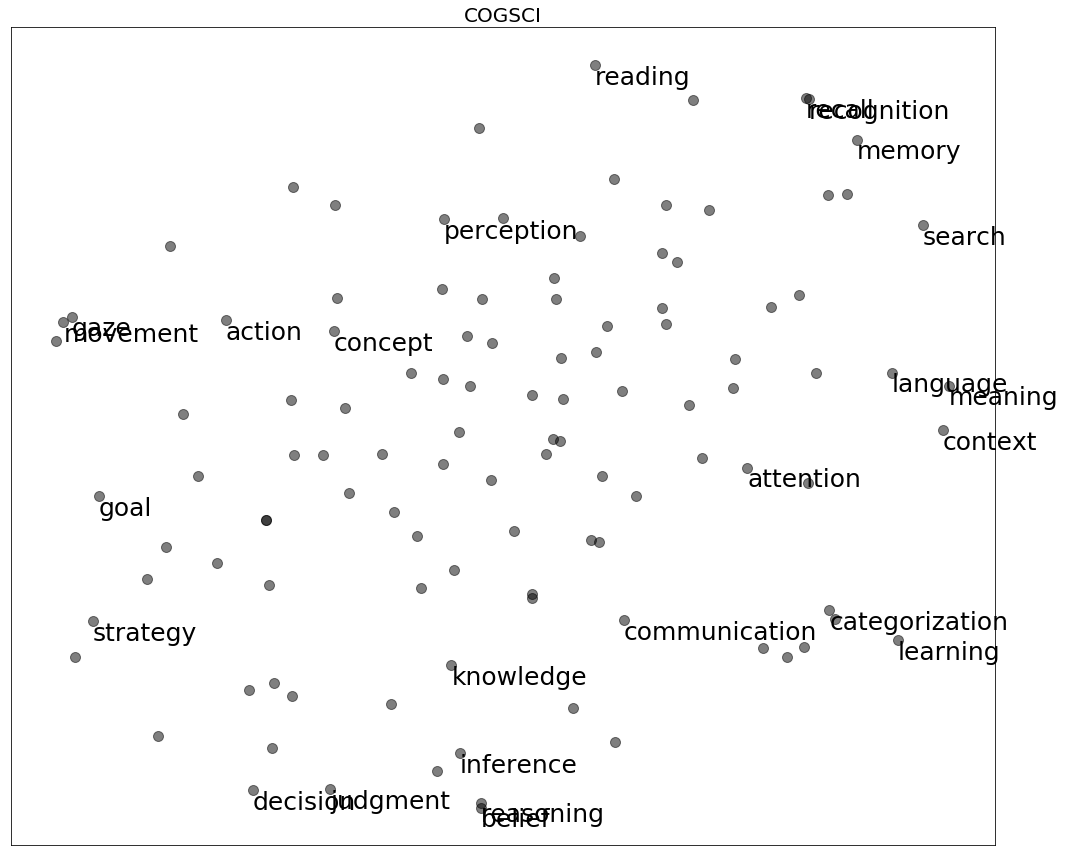

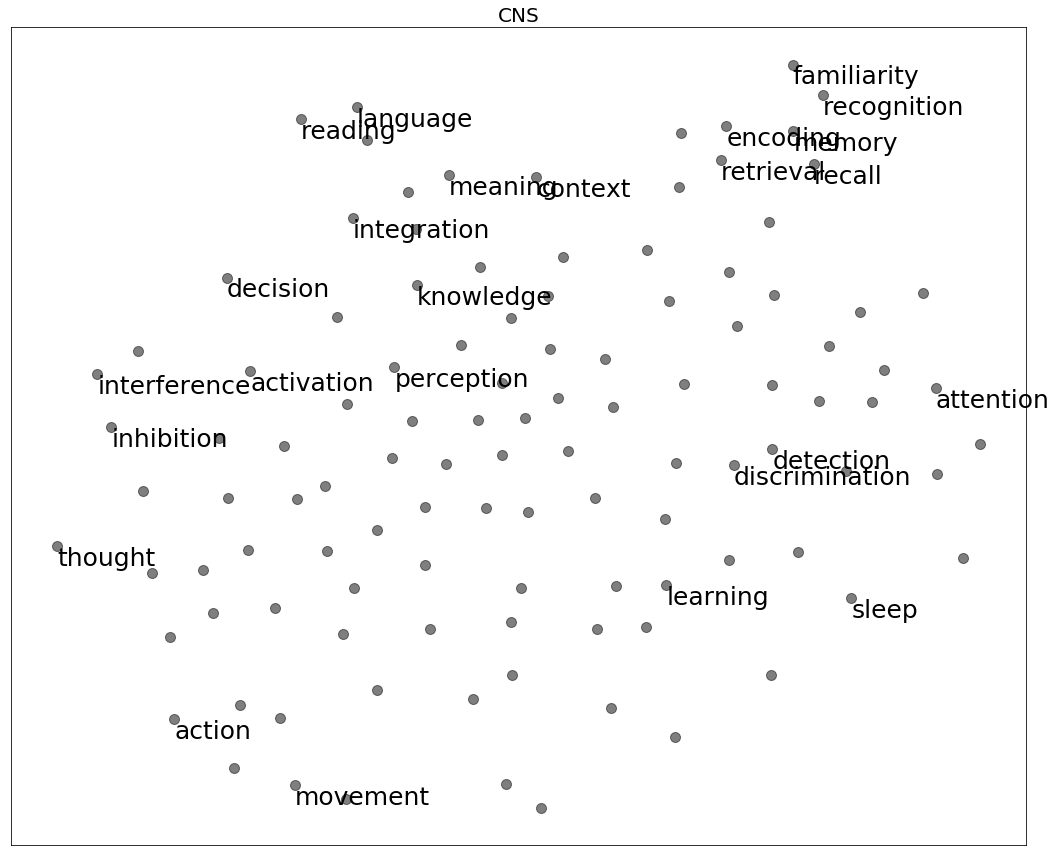

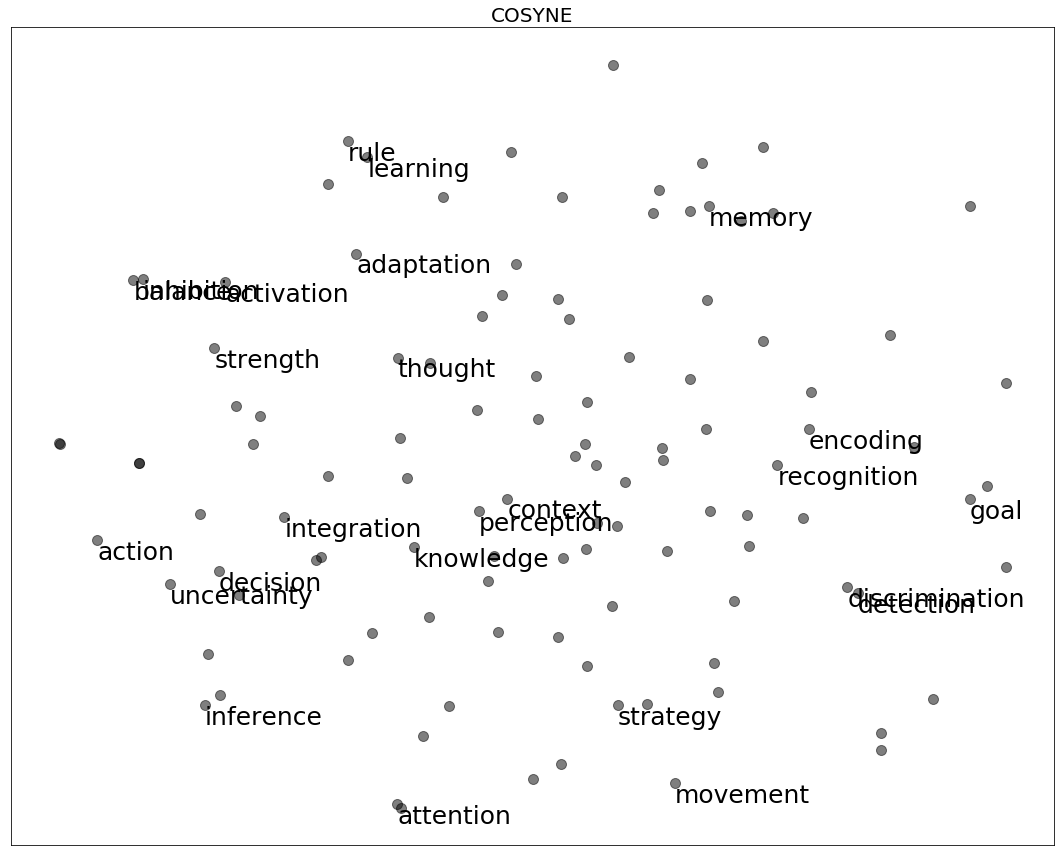

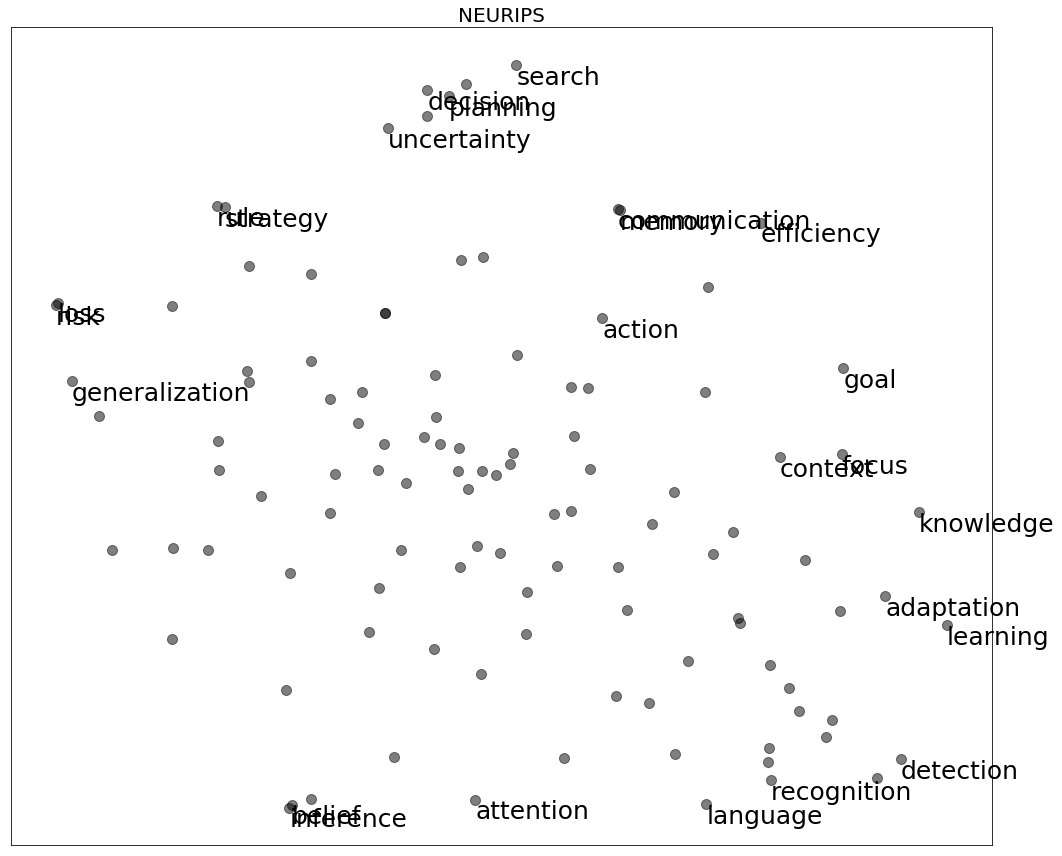

In [10]:
use_common_terms = True
proj_method = 'TSNE'
n_to_label = 25
for m_i, m in enumerate(wv_models):
    vocab = m.wv.index2word
    if use_common_terms:
    # this uses the overlapping terms only
        subset_inds = co.return_subset_inds(vocab, np.array(terms_concat)[agg_valid_inds])
        top_inds, top_counts, top_terms = co.get_top_terms(m, agg_valid_terms.tolist(), topn=n_to_label)
    # this uses all cognitive terms
    else:
        subset_inds = co.return_subset_inds(vocab, terms_concat)
        top_inds, top_counts, top_terms = co.get_top_terms(m, terms_concat, topn=n_to_label)        
    
    if proj_method == 'UMAP':
        projection = umap.UMAP().fit_transform(m.wv.vectors_norm[subset_inds])
    elif proj_method == 'TSNE':
        projection = manifold.TSNE(n_components=2).fit_transform(m.wv.vectors_norm[subset_inds])

    plt.figure(figsize=(15,12))
    plt.scatter(projection[:,0], projection[:,1], s=100, c='k', alpha=0.5, marker='o')
    # COLOR BY KL, bright means high KL
    #plt.scatter(projection[:,0], projection[:,1], s=300, c=avg_KL, alpha=0.8, marker='o', edgecolor='k', cmap='autumn')
    for t_i, t in enumerate(top_terms):
        # do some more gymnastics to get equivalent index in the subset
        s_i = subset_inds.index(top_inds[t_i])
        plt.text(projection[s_i,0], projection[s_i,1], t, ha="left", va="top", rotation=0, fontsize=25)
    plt.title(corpora[m_i].upper(), fontsize=20)
    plt.box('off');plt.xticks([]);plt.yticks([])
    plt.tight_layout()
#    plt.savefig('../figures/%s_proj2d_%s.png'%(proj_method, corpora[m_i]))

# Hierarchical Clustering

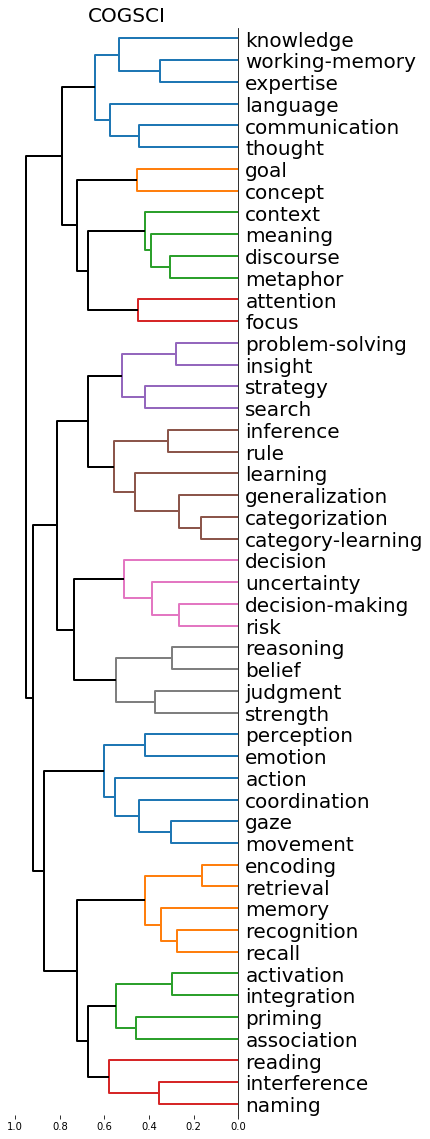

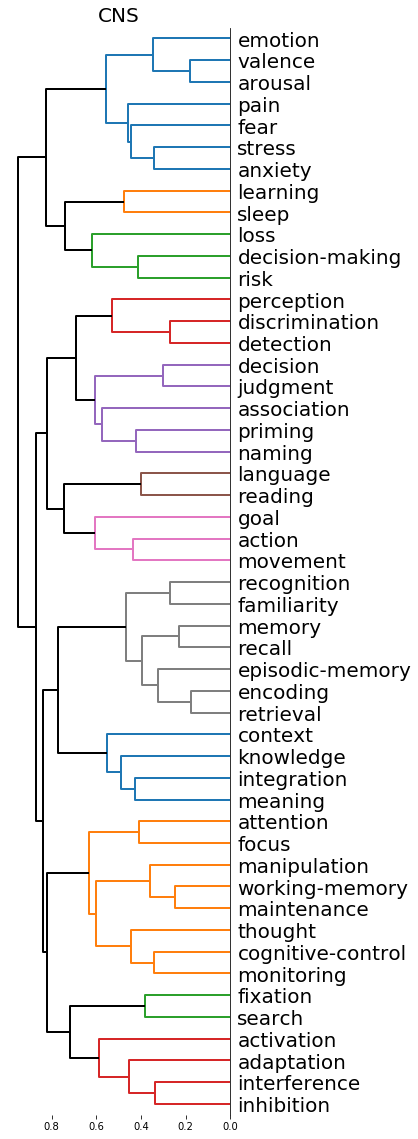

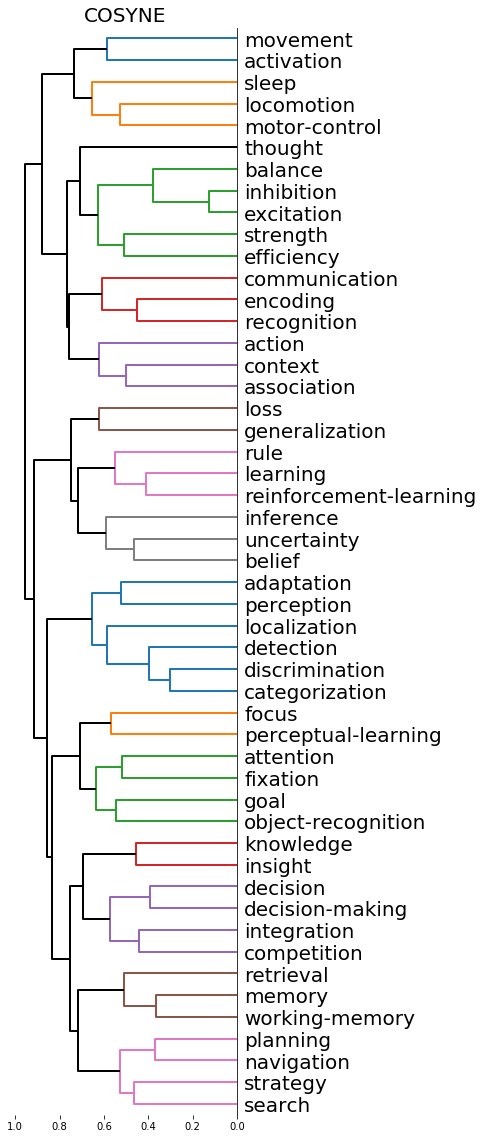

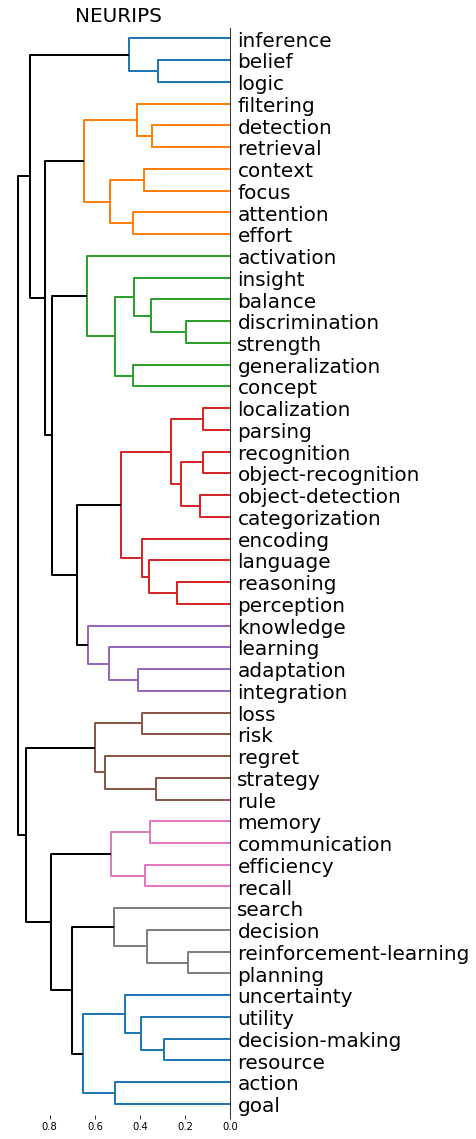

In [11]:
for m_i, m in enumerate(wv_models):
    plt.figure(figsize=(4,20))
    top_inds, top_counts, top_terms = co.get_top_terms(m, terms_concat, topn=50)

    # clustering
    Y = cluster.hierarchy.linkage(m.wv.vectors_norm[top_inds], method='complete', metric='cosine')
    Z = cluster.hierarchy.dendrogram(Y,
                   orientation='left',
                   labels=top_terms,
                   leaf_font_size=20,
                   above_threshold_color='k')
    plt.gca().invert_yaxis(); co.remove_spines(plt.gca(),['top','left', 'bottom'])
    plt.title(corpora[m_i].upper(), fontsize=20)
#    plt.savefig('../figures/hierarchical_%s.png'%corpora[m_i], bbox_inches='tight')


# Ontology over time

In [12]:
convert_to_sentences = False
corpora = ['cogsci', 'cns', 'cosyne', 'neurips']
c = corpora[0]
abstract_file = '../data/abstracts_'+c+'_combined.csv'

print('-------%s over time--------'%c.upper())
df_corp = pd.read_csv(abstract_file, header=0, index_col=False, usecols=['Year', 'Title', 'Abstract'], na_filter=True)
print('%i documents extracted. %i with title and abstracts.' %(len(df_corp),len(df_corp.dropna())))    

wv_models_year=[]
print(df_corp.groupby('Year').count())
year_rngs = [2010, 2013, 2016, 2019]
for y_i, year in enumerate(year_rngs[:-1]):
    print('Converting to sentence-level representation & concatenating terms.')
    df_years = df_corp[np.logical_and(df_corp['Year']>=year, df_corp['Year']<year_rngs[y_i+1])]
    stcs = co.doc_to_stcs(df_corp)
    stcs, terms_concat = co.concat_terms(stcs, terms['Terms'].values)
    print('Training word2vec model.')
    cur_wv_model = gs.models.Word2Vec(stcs, min_count=2, size=100, window=10, sg=1)
    wv_models_year.append(cur_wv_model)
    print(' ')

-------COGSCI over time--------
6385 documents extracted. 6379 with title and abstracts.
      Title  Abstract
Year                 
2010    683       678
2011    849       849
2012    756       756
2013    996       995
2014    786       786
2015    680       680
2016    721       721
2017    914       914
Converting to sentence-level representation & concatenating terms.
Training word2vec model.
 
Converting to sentence-level representation & concatenating terms.
Training word2vec model.


KeyboardInterrupt: 

In [ ]:
dissim = False
cmap = 'RdBu' if dissim else 'PuBu'
top_n = 10
positive = ['working-memory']
negative = ['memory']

df_similarity = co.query_similarity(wv_models_year, year_rngs[1:], positive, negative, top_n, terms_concat, dissim)
co.print_fancy_similarity(df_similarity, cmap)

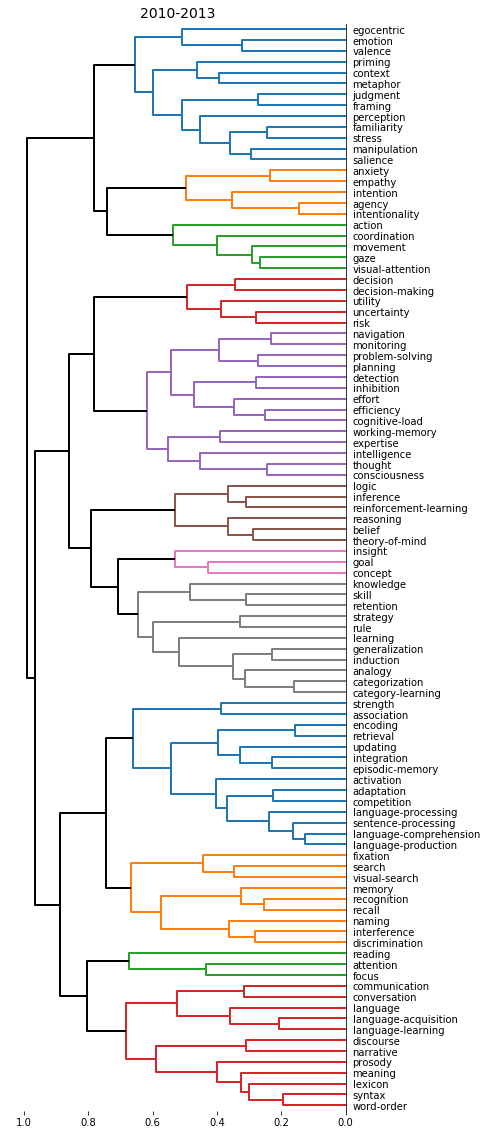

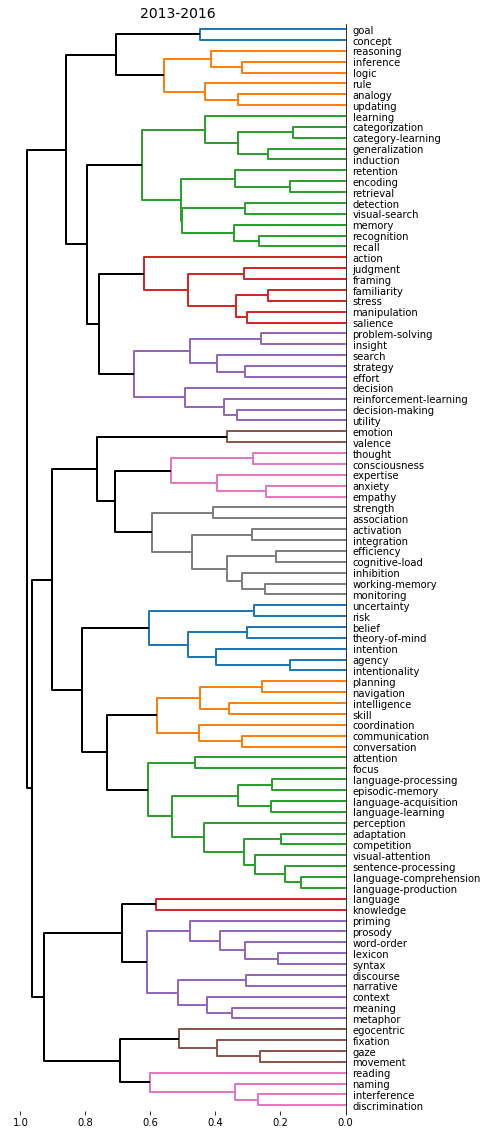

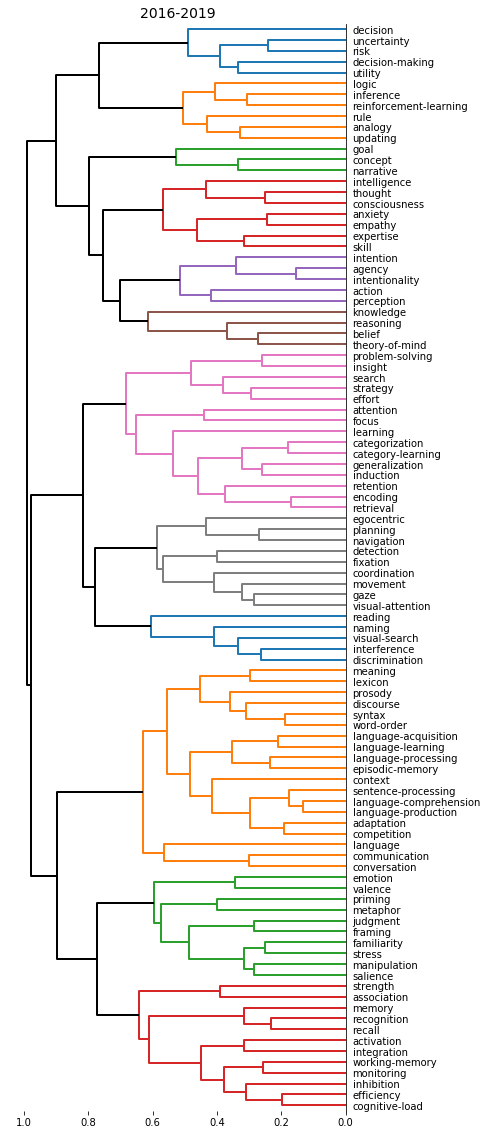

In [84]:
for m_i, m in enumerate(wv_models_year):
    year_label = '%i-%i'%(year_rngs[m_i],year_rngs[m_i+1])
    plt.figure(figsize=(6,20))
    top_inds, top_counts, top_terms = co.get_top_terms(m, terms_concat, topn=100)

    # clustering
    Y = cluster.hierarchy.linkage(m.wv.vectors_norm[top_inds], method='complete', metric='cosine')
    Z = cluster.hierarchy.dendrogram(Y,
                   orientation='left',
                   labels=top_terms,
                   leaf_font_size=10,
                   above_threshold_color='k')
    plt.gca().invert_yaxis(); co.remove_spines(plt.gca(),['top','left', 'bottom'])
    plt.title(year_label, fontsize=14)
    plt.savefig('../figures/hierarchical_overtime_%s_%s.png'%(c,year_label), bbox_inches='tight')


# Quantitative group comparison
Ideally, we'd like to directly compare the word vectors for the same word learned across corpora, but there is rotational problems (?), so we can do an intra-corpus comparison first, then compare the comparison across corpora. Essentially this boils down to the intra-corpora similarity values, and how similar the neighbors are.
Vague plan:
- get word vectors of subset
- Jacard distance of neighbors in the set
- Get corpus similarity matrix and find similarity between TWO similarity matrix
- Similarity distribution of the same word in two languages should be similar
- Distributional semantics
- Comparison across corpora or time
- cross-corp synonym
- KL divergence of similarity distributions

In [13]:
def find_top_n(simmat, top_n):
    topn_inds = [np.argsort(simmat[i_t,:])[::-1][1:top_n+1] for i_t in range(simmat.shape[0])]
    topn_sims = [simmat[i_t,topn_inds[i_t]] for i_t in range(simmat.shape[0])]
    return topn_inds, topn_sims

def compute_jaccard(most_sim1, most_sim2):
    jaccard_dist = np.zeros((len(most_sim1),len(most_sim1)))
    for i_t in range(len(most_sim1)):
        for j_t in range(len(most_sim2)):
            jaccard_dist[i_t, j_t] = len(np.intersect1d(most_sim1[i_t], most_sim2[j_t]))/len(np.union1d(most_sim1[i_t], most_sim2[j_t]))
    return jaccard_dist

def KL(v1,v2,bins):
    epsilon = 1e-6
    P = np.histogram(v1, bins)[0]
    Q = np.histogram(v2, bins)[0]
    P=P/P.sum()
    Q=Q/Q.sum()
    divergence = np.sum((P+epsilon)*np.log2((P+epsilon)/(Q+epsilon)))
    return divergence

In [14]:
# this gets all overlaping words between the corpora
agg_subset_inds = np.array([co.return_subset_inds(model.wv.index2word, terms_concat, True) for model in wv_models])
agg_valid_inds = np.where(np.array(~np.isnan(agg_subset_inds.sum(0))))[0].astype(int)
agg_valid_terms = terms.iloc[np.array(~np.isnan(agg_subset_inds.sum(0)))]['Terms'].values.tolist()

# thresholding based on counts in each corpus
# get the counts of all common words
count_thresh = 3
agg_subset_counts = np.array([[model.wv.vocab[term].count for term in np.array(terms_concat)[agg_valid_inds]] for model in wv_models])

# get only the words that are above count threshold
agg_valid_inds = agg_valid_inds[(agg_subset_counts>=count_thresh).all(0)]
agg_valid_terms = np.array(agg_valid_terms)[(agg_subset_counts>=count_thresh).all(0)]
print(len(agg_valid_inds))

111


In [15]:
vec_len = wv_models[0].wv.vectors_norm.shape[1]
agg_vecs = np.zeros((len(wv_models),len(terms_concat), vec_len))
agg_simmat = np.zeros((len(wv_models), len(terms_concat), len(terms_concat)))
for i_m in range(len(wv_models)):
    # loop over models to grab vectors
    m = wv_models[i_m]
    if type(m.wv.vectors_norm) == type(None):
        # initialize similarity if it has not happened
        m.init_sims()
    for i_t in range(len(terms_concat)):
        # grab subset of vectors that are in the ontology dictionary
        if ~np.isnan(agg_subset_inds[i_m, i_t]):
            agg_vecs[i_m, i_t, :] = m.wv.vectors_norm[int(agg_subset_inds[i_m, i_t])]
        
    # compute cosine similarity
    agg_simmat[i_m,:,:] = metrics.pairwise.cosine_similarity(agg_vecs[i_m,:,:])
    
agg_simmat[agg_simmat<0]=0 # not sure why some values are 0, replace

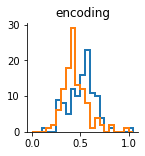

In [16]:
plt.figure(figsize=(2,2))
query_word = 28
for i_m in range(2):
    plt.hist(agg_simmat[i_m,agg_valid_inds[query_word],agg_valid_inds], np.arange(0.0,1.1,0.05), histtype='step', lw=2)

plt.title(agg_valid_terms[query_word]);
sns.despine()

In [17]:
# compute KL divergence of similarity distributions
bins = np.linspace(0,1,21)
full_dist = False
agg_KL = np.zeros((len(corpora),len(corpora),len(agg_valid_inds)))
for i_m in range(len(wv_models)):
    for j_m in range(len(wv_models)):
        for i_q, q in enumerate(agg_valid_inds):
            if full_dist:
                # use full distribution of similarity values
                agg_KL[i_m, j_m, i_q] = KL(agg_simmat[i_m, q, :], agg_simmat[j_m,q, :], bins)
            else:
                # use subset of only valid ones
                agg_KL[i_m, j_m, i_q] = KL(agg_simmat[i_m, q, agg_valid_inds], agg_simmat[j_m,q, agg_valid_inds], bins)

In [18]:
n_top_translatable = 20
plt.figure(figsize=(10,3))
avg_KL = agg_KL.mean(0).mean(0)
plt.stem(np.sort(avg_KL)[:n_top_translatable], markerfmt='ko', linefmt='-k', ms=50, basefmt='w')
plt.ylim([0,1])
plt.xticks(np.arange(n_top_translatable), agg_valid_terms[np.argsort(avg_KL)], ha='left', rotation=-45, fontsize=20);
plt.yticks(fontsize=15)
sns.despine()

TypeError: stem() got an unexpected keyword argument 'ms'

<Figure size 720x216 with 0 Axes>

In [19]:
n_top_translatable = 20
plt.figure(figsize=(10,3))
avg_KL = agg_KL.mean(0).mean(0)
plt.stem(np.sort(avg_KL)[-n_top_translatable:], markerfmt='ko', linefmt='-k', ms=50, basefmt='w')
plt.ylim([0,6])
plt.xticks(np.arange(n_top_translatable), agg_valid_terms[np.argsort(avg_KL)[-n_top_translatable:]], ha='left', rotation=-45, fontsize=20);
plt.yticks(fontsize=15)
sns.despine()

TypeError: stem() got an unexpected keyword argument 'ms'

<Figure size 720x216 with 0 Axes>

In [20]:
query_word = 94
source_corp, target_corp = 0,3
print(agg_valid_terms[query_word])
np.array(agg_valid_terms)[np.argsort(co.compute_similarity(agg_vecs[source_corp,agg_valid_inds[query_word],:], agg_vecs[target_corp, agg_valid_inds,:] ))[::-1][:10]]

semantic information


array(['lying', 'desire', 'interference', 'updating', 'error detection',
       'maintenance', 'prototype', 'attachment', 'memory retrieval',
       'fixation'], dtype='<U24')

In [21]:
# find top n terms for all corpora
top_n=10
agg_topn_inds = [find_top_n(agg_simmat[c_i,:,:][:,agg_valid_inds][agg_valid_inds,:], top_n)[0] for c_i in range(agg_simmat.shape[0])]

In [22]:
source_corp, target_corp = 0, 2
query_word = 20 # 20, 50, 55, 123
print(agg_valid_terms[query_word])
jaccard_dist = compute_jaccard(agg_topn_inds[source_corp], agg_topn_inds[target_corp])
synonym, synonym_jacc = co.sort_similarity(jaccard_dist[query_word,:])

np.array(agg_valid_terms)[synonym[:10]]
#print(agg_valid_terms.iloc[agg_topn_inds[source_corp][query_word]])
#co.sort_similarity(agg_simmat[0,agg_valid_inds[query_word],agg_valid_inds])[0]

decision


array(['lying', 'resource', 'integration', 'multisensory',
       'working memory', 'discrimination', 'insight', 'risk', 'fixation',
       'skill'], dtype='<U24')

# Consistency of corpora
### as measured by how many terms are "similar" across corpora
using Jaccard distance, find the top N most similar words, then with a synonym cutoff threshold (n_syn_thres), if the queried word is in the subset of the top few words, then the corpora are considered "close"

Jaccard similarity matrix is **not** symmetric when computed for a pair of corpus. Word A in corpus 1 has a different set of neighbors than word A in corpus 2, so `compute_jaccard(source, target)!=compute_jaccard(target, source)`.

But `compute_jaccard(source, target)==compute_jaccard(target, source).T`.

In [23]:
n_synonyms = 10
agg_synonyms = np.zeros((len(corpora),len(corpora),len(agg_valid_inds), n_synonyms))
for source_corp in range(len(corpora)):
    for target_corp in range(len(corpora)):
        # compute all pairwise jaccard dist between two corpora
        agg_jaccard_dist = compute_jaccard(agg_topn_inds[source_corp], agg_topn_inds[target_corp])
        # do ranking to find synonyms
        for query_word in range(len(agg_valid_inds)):
            #agg_synonyms[source_corp, target_corp, query_word,:] = co.sort_similarity(agg_jaccard_dist[query_word,:])[0][:n_synonyms]                
            agg_synonyms[source_corp, target_corp, query_word,:] = np.argsort(agg_jaccard_dist[query_word,:])[::-1][:n_synonyms]                
            
            

[[100.          24.32432432   8.10810811   5.40540541]
 [ 20.72072072 100.          12.61261261   3.6036036 ]
 [ 10.81081081  15.31531532 100.           8.10810811]
 [  4.5045045    2.7027027    5.40540541 100.        ]]


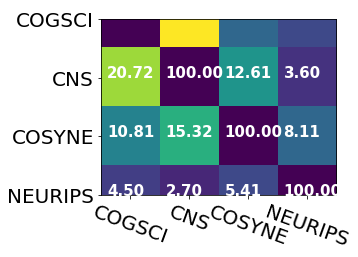

In [29]:
n_syn_thresh = 2

# look across all words for corpus translatability
# np.any finds if any of the top 3 most Jaccard similar words in the other corpus matches
agg_translatable = np.zeros(agg_synonyms.shape[:3])
for query_word in range(len(agg_valid_inds)):
    agg_translatable[:,:,query_word] = (agg_synonyms[:,:,query_word,:n_syn_thresh]==query_word).any(-1).astype(int)

pct_translatable = agg_translatable.sum(-1)/len(agg_valid_inds)*100
print(pct_translatable)

plt.figure(figsize=(5,7))
plt.imshow(pct_translatable-np.eye(4)*100)
for i in range(4):
    for j in range(4):
        plt.text(i-0.4,j,'%.2f'%pct_translatable[j,i], color='w', fontsize=15, fontweight='heavy')

plt.xticks(np.arange(4),[c.upper() for c in corpora], fontsize=20, rotation=-20)
plt.yticks(np.arange(4),[c.upper() for c in corpora], fontsize=20)
plt.tight_layout()

In [25]:
# which words are translatable
source_corp = 2
print('--------%s----------'%corpora[source_corp])
combined_synonyms = []
for i_c in range(len(corpora)):
    if i_c != source_corp:
        overlap = np.array(agg_valid_terms)[agg_translatable[source_corp,i_c,:]==1]
        # overlap = np.array(agg_valid_terms)[agg_translatable[i_c,source_corp,:]==1]
        print('%s: %i'%(corpora[i_c], len(overlap)))
        print(overlap)
        combined_synonyms.append(np.sort(overlap)[:8])

# proportion of unique words out of whole set
print(len(np.unique(np.concatenate(combined_synonyms)))/len(np.concatenate(combined_synonyms)))
pd.DataFrame(combined_synonyms,index=[corpora[0].upper(),corpora[1].upper(),corpora[3].upper()]).T

--------cosyne----------
cogsci: 12
['gaze' 'meaning' 'memory' 'object recognition' 'perception' 'retrieval'
 'risk' 'skill' 'spatial attention' 'uncertainty' 'utility'
 'visual attention']
cns: 17
['competition' 'decision' 'detection' 'fixation' 'forgetting' 'inference'
 'language' 'logic' 'loss' 'meaning' 'navigation' 'pattern recognition'
 'retention' 'retrieval' 'rule' 'sleep' 'spatial attention']
neurips: 9
['categorization' 'coordination' 'decision' 'inference' 'knowledge'
 'learning' 'locomotion' 'manipulation' 'reinforcement learning']
0.9166666666666666


,COGSCI,CNS,NEURIPS
0,gaze,competition,categorization
1,meaning,decision,coordination
2,memory,detection,decision
3,object recognition,fixation,inference
4,perception,forgetting,knowledge
5,retrieval,inference,learning
6,risk,language,locomotion
7,skill,logic,manipulation


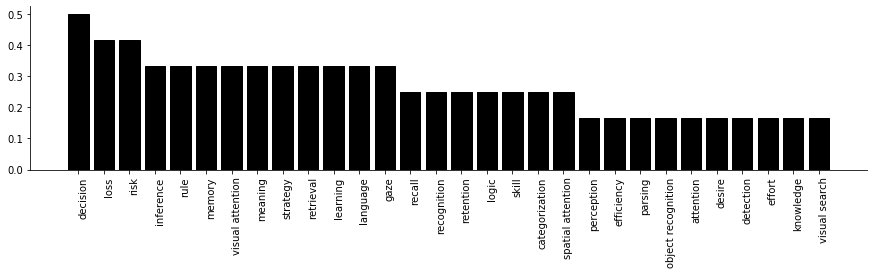

In [26]:
n_top_translatable = 30#len(agg_valid_terms)
agg_translatable_ranked = (agg_translatable.sum(0).sum(0)-len(corpora))/12

plt.figure(figsize=(15,3))
plt.bar(np.arange(n_top_translatable), np.sort(agg_translatable_ranked)[::-1][:n_top_translatable], fc='k', ec='k')
plt.xticks(np.arange(n_top_translatable), 
           np.array(agg_valid_terms)[np.argsort(agg_translatable_ranked)[::-1]][:n_top_translatable],
          rotation=90, ha='left', fontsize=10)
sns.despine()

In [27]:
agg_translatable[:,:,-1]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])